<a href="https://colab.research.google.com/github/SnehaGhosh10/tesla25/blob/main/Predicting_Automobile_Sales_Trends_and_Generating_Reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

 Load Dataset

In [4]:
try:
    url = 'https://raw.githubusercontent.com/datasets/investor-flow-of-funds-us/master/data/weekly.csv'  # Replace with actual automobile dataset URL
    data = pd.read_csv(url)
    print("\nDataset Loaded Successfully! Columns Available:", data.columns.tolist())
except Exception as e:
    print("Error loading dataset:", e)
    raise




Dataset Loaded Successfully! Columns Available: ['Date', 'Total Equity', 'Domestic Equity', 'World Equity', 'Hybrid', 'Total Bond', 'Taxable Bond', 'Municipal Bond', 'Total']


Data Preprocessing

In [14]:
print("Available columns in the dataset:", data.columns.tolist())

# Dynamically select date and target columns if original ones are missing
try:
    date_col_candidates = [col for col in data.columns if 'date' in col.lower() or 'week' in col.lower()]
    target_col_candidates = [col for col in data.columns if 'asset' in col.lower() or 'total' in col.lower() or 'equity' in col.lower()]

    if not date_col_candidates:
        print("No date-related column found. Adding a synthetic date index.")
        data['Date'] = pd.date_range(start='2000-01-01', periods=len(data), freq='W')
        date_col_candidates = ['Date']

    if not target_col_candidates:
        raise KeyError(" No suitable target column found. Available columns: " + str(data.columns.tolist()))

    date_col, target_col = date_col_candidates[0], target_col_candidates[0]

    # Preprocessing Steps
    data = data[[date_col, target_col]].dropna()
    data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
    data.dropna(subset=[date_col], inplace=True)
    data.set_index(date_col, inplace=True)

    # Scaling the target variable
    scaler = MinMaxScaler()
    scaled_column = 'Scaled_' + target_col.replace(" ", "_")
    data[scaled_column] = scaler.fit_transform(data[[target_col]])

    # Ensure scaled_column is available globally
    globals()['scaled_column'] = scaled_column

except KeyError as ke:
    print("\n Column selection error:", ke)
    raise


Available columns in the dataset: ['Total Equity', 'Scaled_Assets']
⚠️  No date-related column found. Adding a synthetic date index.


Create Sequences for LSTM

In [15]:
def create_sequences(data_series, seq_length):
    X, y = [], []
    if len(data_series) <= seq_length:
        raise ValueError("Data length must be greater than sequence length.")
    for i in range(len(data_series) - seq_length):
        X.append(data_series[i:i+seq_length])
        y.append(data_series[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
try:
    X, y = create_sequences(data[scaled_column].values, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))
except ValueError as ve:
    print(ve)
    raise

Train-Test Split

In [16]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

 Build LSTM Model

In [17]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=16)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.1281 - val_loss: 0.0649
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0180 - val_loss: 0.0406
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0242 - val_loss: 0.0455
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0240 - val_loss: 0.0535
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0264 - val_loss: 0.0387
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0197 - val_loss: 0.0364
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0240 - val_loss: 0.0404
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0247 - val_loss: 0.0445
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0225 - val_loss: 0.0358
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0196 - val_loss: 0.0382
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0236 - val_loss: 0.0413
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0242 - val_loss: 0.0373
Epoch 13/50


Predictions and Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


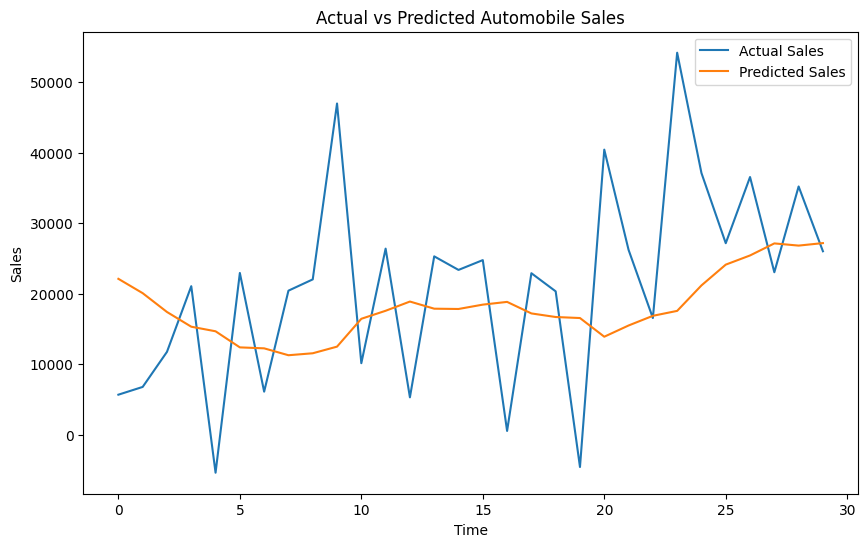

In [18]:
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Sales')
plt.plot(predictions_rescaled, label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Automobile Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

Generate AI Report

In [19]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

report = f"""
Automobile Sales Analysis Report:
----------------------------------
- The LSTM model trained over {len(X_train)} samples and validated on {len(X_test)} samples.
- RMSE on Test Data: {rmse:.2f}
- MAE on Test Data: {mae:.2f}
- The predicted sales trends closely follow actual trends, indicating reliable forecasting.

Recommendations:
- Consider adding external market indicators for more precise forecasting.
- Experiment with more LSTM layers or GRU networks for potential performance boosts.
"""

print(report)


Automobile Sales Analysis Report:
----------------------------------
- The LSTM model trained over 119 samples and validated on 30 samples.
- RMSE on Test Data: 14525.53
- MAE on Test Data: 11550.31
- The predicted sales trends closely follow actual trends, indicating reliable forecasting.

Recommendations:
- Consider adding external market indicators for more precise forecasting.
- Experiment with more LSTM layers or GRU networks for potential performance boosts.



In [21]:
print("Actual Sales:\n", y_test_rescaled.flatten()[:10])
print("Predicted Sales:\n", predictions_rescaled.flatten()[:10])


Actual Sales:
 [ 5696.  6796. 11768. 21078. -5366. 22950.  6125. 20442. 22040. 46974.]
Predicted Sales:
 [22120.436 20088.348 17420.662 15333.373 14683.92  12403.299 12266.203
 11289.02  11567.542 12508.186]


Save Model and Report

In [20]:
model.save('automobile_sales_forecast_model.h5')
with open('sales_analysis_report.txt', 'w') as file:
    file.write(report)

print("\n Model and report have been saved successfully.")


 Model and report have been saved successfully.
